In [1]:
import ast 
import time 
import random 
import pandas as pd 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

import openai
import json 

In [2]:
test_df = pd.read_csv('/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_test_data.csv')
test_df.head(5)

,task_id,question,choices
0,k10171,Question: What will be output of the following...,"['10', '9', '8', 'Error']"
1,k10182,Question: Consider line 3. Identify the compil...,"['No compilation error', 'Only a lexical error..."
2,k10184,Question: Assume the conflicts part (a) of thi...,['Equal precedence and left associativity; exp...
3,k10206,Question: What will be output if you will exec...,"['2.00000', '4.00000', '6.00000', 'Compilation..."
4,k10215,Question: Select the output for code :\nstatic...,"['amish', 'ANKIT', 'harsh', 'Compile time error']"


In [3]:
def create_full_question(row):
    question = row['question']
    choices_str = row['choices']
    choices = ast.literal_eval(choices_str)
    
    formatted_choices = '\n'.join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)])
    full_question = f"{question}\n{formatted_choices}"
    return full_question

test_df['full_question'] = test_df.apply(create_full_question, axis=1)
test_df.head(5)

,task_id,question,choices,full_question
0,k10171,Question: What will be output of the following...,"['10', '9', '8', 'Error']",Question: What will be output of the following...
1,k10182,Question: Consider line 3. Identify the compil...,"['No compilation error', 'Only a lexical error...",Question: Consider line 3. Identify the compil...
2,k10184,Question: Assume the conflicts part (a) of thi...,['Equal precedence and left associativity; exp...,Question: Assume the conflicts part (a) of thi...
3,k10206,Question: What will be output if you will exec...,"['2.00000', '4.00000', '6.00000', 'Compilation...",Question: What will be output if you will exec...
4,k10215,Question: Select the output for code :\nstatic...,"['amish', 'ANKIT', 'harsh', 'Compile time error']",Question: Select the output for code :\nstatic...


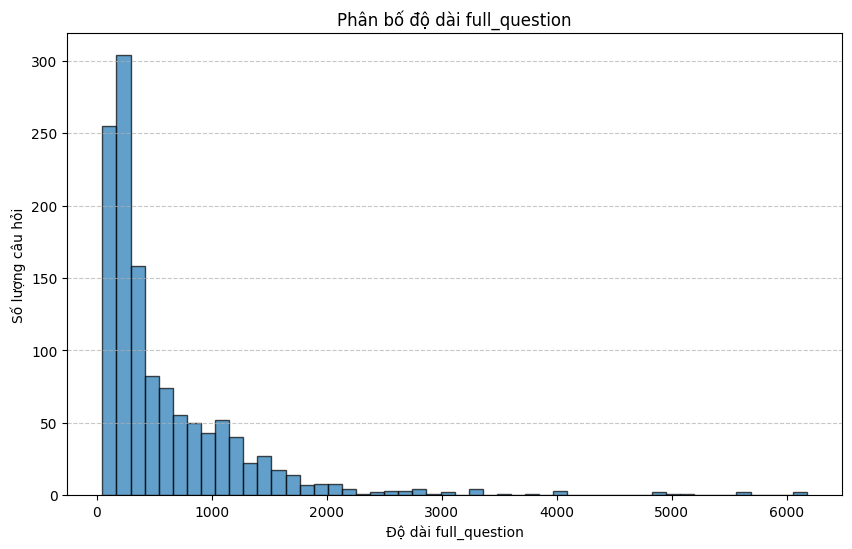

In [4]:
test_df["question_length"] = test_df["full_question"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(test_df["question_length"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Độ dài full_question")
plt.ylabel("Số lượng câu hỏi")
plt.title("Phân bố độ dài full_question")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [5]:
print(len(test_df))

1253


In [6]:
print(test_df.iloc[0]['full_question'])

Question: What will be output of the following c code?
#include<stdio.h>
int main()
{
    int a= sizeof(signed) +sizeof(unsigned);
    int b=sizeof(const)+sizeof(volatile);
    printf("%d",a+++b);
    return 0;
}
A. 10
B. 9
C. 8
D. Error


In [7]:
print(test_df.iloc[1]['full_question'])

Question: Consider line 3. Identify the compiler’s response about this line while creating the object-module
Int main()
{ int 1,N;
Fro (I,1 N,1);
}
A. No compilation error
B. Only a lexical error
C. Only syntactic errors
D. Both lexical and syntactic errors


In [8]:
def read_key(file_path):
    with open(file_path, "r") as f:
        return f.read().strip()

GPT_KEY = read_key("/kaggle/input/api-key/key/gpt_key.txt")

In [9]:
def ask_gpt(question):
    client = openai.OpenAI(api_key=GPT_KEY)

    prompt = (
        "You are an expert AI model trained to answer multiple-choice programming-related questions with the highest accuracy. "
        "Your goal is to analyze the question carefully and select the correct answer based on programming knowledge and logical reasoning.\n\n"
        "Guidelines:\n"
        "- Only respond with a single letter: A, B, C, or D.\n"
        "- Do not provide any explanation or additional text.\n"
        "- Ensure your response strictly follows the multiple-choice format.\n\n"
        f"Question:\n{question}\n\n"
        "Provide your answer as a single letter (A, B, C, or D):"
    )

    while True:
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}],
                temperature=0 
            )

            answer = response.choices[0].message.content.strip()
            valid_choices = {"A", "B", "C", "D"}

            return answer if answer in valid_choices else "unknown"

        except openai.APIError as e:
            print(f"Error: {e}. Retrying in 60 seconds...")
            time.sleep(60)


In [10]:
question = """
Question: Consider line 3. Identify the compiler’s response about this line while creating the object-module
Int main()
{ int 1,N;
Fro (I,1 N,1);
}
A. No compilation error
B. Only a lexical error
C. Only syntactic errors
D. Both lexical and syntactic errors
"""

result = ask_gpt(question)
print(result)

D


In [11]:
def generate_answers(df, is_test=False):
    correct_count = 0
    gpt_answers = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Questions"):
        question = row["full_question"]
        gpt_answer = ask_gpt(question)
        gpt_answers.append(gpt_answer)

        if not is_test:
            correct_count += (gpt_answer == row["answer"])

    if is_test:
        return gpt_answers, None
    else:
        accuracy = correct_count / len(df) * 100
        return gpt_answers, accuracy

In [12]:
num_samples = len(test_df)
test_df_subset = test_df.head(num_samples).copy()
gpt_answers, accuracy = generate_answers(test_df_subset, is_test=True)
test_df_subset["gpt_answers"] = gpt_answers

Processing Questions: 100%|██████████| 1253/1253 [13:09<00:00,  1.59it/s]


In [13]:
print(f"Accuracy: {accuracy}%")

Accuracy: None%


In [14]:
submission_df = test_df_subset[["task_id", "gpt_answers"]].rename(columns={"gpt_answers": "answer"})
unknown_count = (submission_df["answer"] == "unknown").sum()
submission_df["answer"] = submission_df["answer"].apply(lambda x: random.choice(["A", "B", "C", "D"]) if x == "unknown" else x)

submission_df.to_csv("submission.csv", index=False)
submission_df.head(5)

,task_id,answer
0,k10171,D
1,k10182,D
2,k10184,A
3,k10206,C
4,k10215,D


In [15]:
print(f"Number of 'unknown' answers: {unknown_count}")

Number of 'unknown' answers: 1


In [16]:
print(submission_df["answer"].value_counts())

answer
B    352
A    339
C    308
D    254
Name: count, dtype: int64
